# Time-Series Forecasting Overview
* Always want to start with a question that you want to answer
    * This question should be concrete and you must believe that it should be able to be answerd with data
    * Ex: What is the expected voter turnout for california for the 2018 midterm elections?
    * Ex: What is the future expected price of apple stock over the next year?
    * Ex: What is the life expectancy of the average US female in 50 years? 
* What is time series data?
    * Data collected on the same metric or same object at regular or irregular time intervals
    * Most data that we work with is in fact time series, we just treat it as time independent and we ignore that dimension
    * Think about biases that may come up if you _don't_ account for time dependencies. For instance, if you have sales information for the summer months and you don't account that sales information during the summer may in fact be different than that of winter...

In [3]:
import io
import datetime

import boto3
import numpy 
import pandas
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="white", palette="husl")
sns.set_context("talk")
sns.set_style("ticks")

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

We will use `io` for working with streams, docs found [here](https://docs.python.org/3/library/io.html). 

In [4]:
# Method 1 to get csv from s3
s3 = boto3.client("s3")
BUCKET_NAME = "intuitiveml-data-sets"
KEY = "reviews.csv"

reviews_csv = s3.get_object(Bucket=BUCKET_NAME, Key=KEY)
df = pandas.read_csv(io.BytesIO(reviews_csv['Body'].read()))

# Method 2
# df = pandas.read_csv(reviews_csv["Body"])

# Method 3
# df = pandas.read_csv("s3://intuitiveml-data-sets/reviews.csv")

In [5]:
# Look at data
display(df.head())

# Look at shape of data
display(df.shape)

# Look at data types, ideally look at all rows. Only look at first five here for minimal output
display(df.iloc[:5, :5].dtypes)

# See if any columns have nulls, Only look at first five here for minimal output
display(df.iloc[:5, :5].isnull().any())

# Display descriptive statistics
display(df.describe(percentiles=[0.25, 0.5, 0.75, 0.85, 0.95, 0.99]))

,listing_id,date
0,109,2011-08-15
1,109,2016-05-15
2,344,2016-06-14
3,344,2016-12-30
4,344,2018-08-28


(1163234, 2)

listing_id     int64
date          object
dtype: object

listing_id    False
date          False
dtype: bool

,listing_id
count,1.163234e+06
mean,1.100989e+07
std,7.539952e+06
min,1.090000e+02
25%,4.076809e+06
50%,1.080537e+07
75%,1.730406e+07
85%,2.001148e+07
95%,2.318428e+07
99%,2.599775e+07


## What are some things that we can do with this data? 
* First, think if the data that you have is sufficient in order to answer your original question
* One thing that we could create is a daily count of reviews for given listing `id`s
    * We could then use this to see how many listing reviews are there on airbnb for any given day
    
* Future questions:
    * Forecast the future number of reviews for the Los Angeles area
    * Forecast the future number of reviews for specific listings in the los angeles area
   
## What techniques may help answer these questions?
### Statisical models
* **Ignore the time series aspect completely using traditional statistical modeling tools**
    * Example: regression based models
    * This isn't a great idea since we are not leveraging the inherent order and structure of the time series data. In modeling we want to leverage as much information as possible. 
* **Univariate statistical time series modeling**
    * Example: Averaging and smoothing models, ARIMA models
* **Slight modifications to univariate statistical time series modeling**
    * Examples: External Regressors, multi-variate models
* **Additive or component models**
    * Examples: Facebook Prophet Package
    * Easy out of the box time series modeling
* **Structural time series modeling**
    * Examples: Bayesian structural time series modeling, hierarchical time series modeling
    * This involves a series of time series models. Some have a lot of data, others have little data. Can utilize bayesian priors in this case.
    
### Machine Learning Models
* **Ignore the time series aspect completely andmodel using traditional machine learning models**
    * Examples: Support vector machines, Random Forest Regression, Gradient-Boosted Decision Trees
* **Hidden Markov Models**
* **Other sequence based models**
* **Gaussian Processes (GPs)**
* **Recurrent neural networks (RNNs)**

### Additional data considerations before choosing a model
* Whether or not to incorporate external data
* Whether to keep as a univariate or multivariate (i.e., which features and number of features)
* Outlier detection and removal
* Missing value imputation

## Process the data

In [6]:
df = df.rename(columns={"date": "ds", "listing_id": "ts"})

# Group data by number of listings per date
df_example = df.groupby(by="ds").agg({"ts": "count"})

In [7]:
# Change index to datetime
df_example.index = pandas.to_datetime(df_example.index)

# Set frequency of time series
df_example = df_example.asfreq(freq="1D")

# Sort the values
df_example = df_example.sort_index(ascending=True)

# Fill Nan values with 0
df_example = df_example.fillna(value=0)

display(df_example.tail())

,ts
ds,
2018-09-04,931.0
2018-09-05,691.0
2018-09-06,505.0
2018-09-07,408.0
2018-09-08,23.0


## Plot our Data

/Users/natedake/.virtualenvs/intuitiveml/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


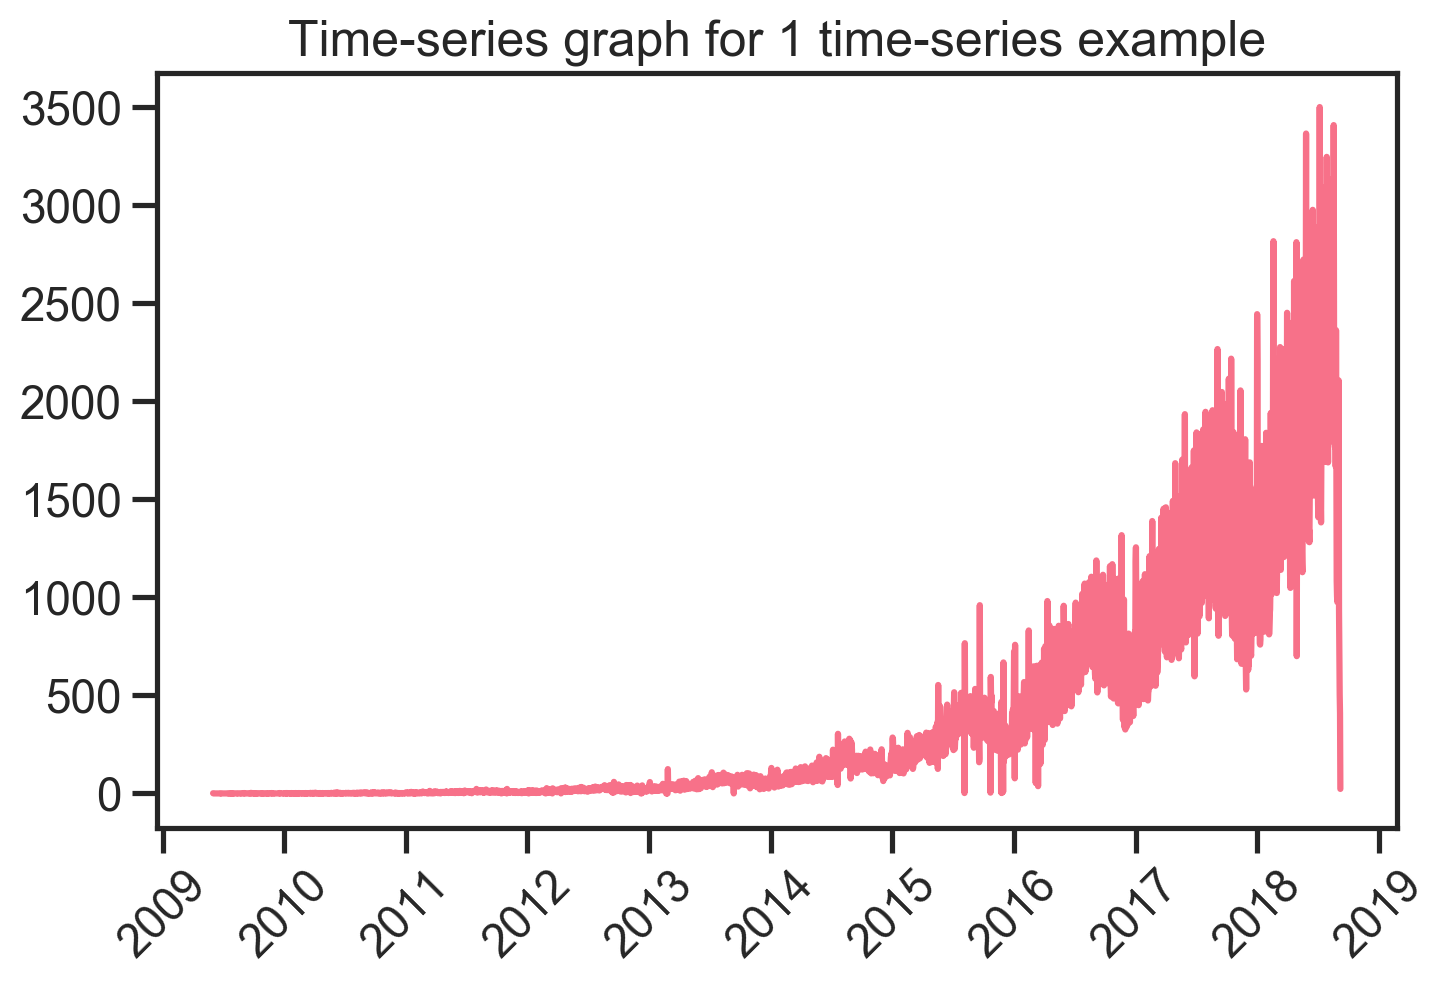

In [8]:
fig, ax = plt.subplots(1,1, figsize=(8,5), dpi=100)

ax.plot(df_example["ts"])

ax.set_title("Time-series graph for 1 time-series example")

ax.tick_params(axis="x", rotation=45)

plt.show()

We can clearly see the following:
* There does appear to be an overal increasing trend
* There appears to be some differences in variance over time
* There may be some seasonality (i.e. cycles) in the data
* Note sure about outliers

Generally, we expect a nice cyclic pattern (think sinusoidal) for our data. Here, it looks nearly like exponential growth. This means that we are going to need to do many things to do this data in order to make it appropriate for time series modeling.

### Look at Stationarity
Most time-series models assume that the underlying time-series data is **stationary**. This assumption gives us some nice statistical properties that allows us to use various models for forecasting.

**Stationarity** is a statistical assumption that a time-series has:
    * **constant mean**
    * **constant variance**
    * **autocovariance does not depend on time**

More simply put, if we are using past data to predict future data, we should assume that the data will follow the same general trends and patterns as in the past. The general statement holds for most training data and modeling tasks.

**There are some good diagrams and explanations on stationarity [here](https://people.duke.edu/~rnau/411diff.htm) and [here](https://www.analyticsvidhya.com/blog/2015/12/complete-tutorial-time-series-modeling/)**.

Sometimes we need to transform the data in order to make it stationary. However, this transformation then calls into question if this data is truly stationary and is suited to be modeled using these techniques.

#### Looking at our data:

Rolling mean and standard deviation look like they change over time. There may be some de-trending and removing seasonality involved. Based on **Dickey-Fuller test**, because p = 0.31, we fail to reject the null hypothesis (that the time series is not stationary) at the p = 0.05 level, thus concluding that we fail to reject the null hypothesis that our **time series is not stationary**.

In [11]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(df, ts):
    """
    Test stationarity using moving average statistics and Dickey-Fuller test
    Source: https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
    """
    
    # Determing rolling statistics
    rolmean = df[ts].rolling(window = 12, center = False).mean()
    rolstd = df[ts].rolling(window = 12, center = False).std()
    
    # Plot rolling statistics:
    orig = plt.plot(df[ts], 
                    color = 'blue', 
                    label = 'Original')
    mean = plt.plot(rolmean, 
                    color = 'red', 
                    label = 'Rolling Mean')
    std = plt.plot(rolstd, 
                   color = 'black', 
                   label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation for %s' %(ts))
    plt.xticks(rotation = 45)
    plt.show(block = False)
    plt.close()
    
    # Perform Dickey-Fuller test:
    # Null Hypothesis (H_0): time series is not stationary
    # Alternate Hypothesis (H_1): time series is stationary
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(df[ts], 
                      autolag='AIC')
    dfoutput = pandas.Series(dftest[0:4], 
                         index = ['Test Statistic',
                                  'p-value',
                                  '# Lags Used',
                                  'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

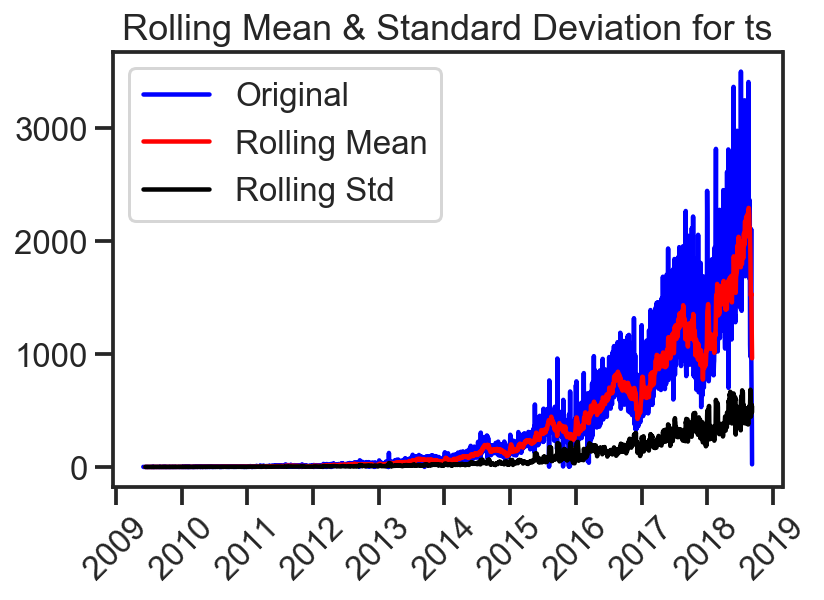

Results of Dickey-Fuller Test:
Test Statistic                   -1.950480
p-value                           0.308699
# Lags Used                      29.000000
Number of Observations Used    3357.000000
Critical Value (1%)              -3.432299
Critical Value (5%)              -2.862401
Critical Value (10%)             -2.567229
dtype: float64


In [12]:
test_stationarity(df=df_example, ts="ts")

In [25]:
# Background on rolling average
test_arr = {"values": (5,10,15,20,25,30)}
df_test = pandas.DataFrame(test_arr)
rolmean = df_test["values"].rolling(window = 2, center = False).mean()
rolmean

## Correct for stationarity

It is common for time series data to have to correct for non-stationarity. 

2 common reasons behind non-stationarity are:

1. **Trend** – mean is not constant over time.
2. **Seasonality** – variance is not constant over time.

There are ways to correct for trend and seasonality, to make the time series stationary.

**What happens if you do not correct for these things?**

Many things can happen, including:
- Variance can be mis-specified
- Model fit can be worse.  
- Not leveraging valuable time-dependent nature of the data.  

Here are some resources on the pitfalls of using traditional methods for time series analysis.  
[Quora link](https://www.quora.com/Why-cant-you-use-linear-regression-for-time-series-data)  
[Quora link](https://www.quora.com/Data-Science-Can-machine-learning-be-used-for-time-series-analysis)  

## Eliminating trend and seasonality
*   **Transformation**
  *   *Examples.* Log, square root, etc.
  *   We are going to look at log.
*   **Smoothing**
  *  *Examples.* Weekly average, monthly average, rolling averages.
  *   We are going to look at weekly average.
*   **Differencing**
  *  *Examples.* First-order differencing.
  *   We are going to look at first-order differencing.
*   **Polynomial Fitting**
  *  *Examples.* Fit a regression model.
*   **Decomposition**

In [27]:
def plot_transformed_data(df, ts, ts_transform):
    """
    Plot transformed and original time series data
    """
    # Plot time series data
    f, ax = plt.subplots(1,1)
    ax.plot(df[ts])
    ax.plot(df[ts_transform], color = 'red')

    # Add title
    ax.set_title('%s and %s time-series graph' %(ts, ts_transform))

    # Rotate x-labels
    ax.tick_params(axis = 'x', rotation = 45)

    # Add legend
    ax.legend([ts, ts_transform])

    plt.show()
    plt.close()

    return

/Users/natedake/.virtualenvs/intuitiveml/lib/python3.6/site-packages/pandas/core/algorithms.py:1813: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]
/Users/natedake/.virtualenvs/intuitiveml/lib/python3.6/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/natedake/.virtualenvs/intuitiveml/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,ts,ts_log,ts_log_moving_avg,ts_moving_avg,ts_log_diff,ts_moving_avg_diff,ts_log_moving_avg_diff,ts_log_ewma,ts_log_ewma_diff
ds,,,,,,,,,
2010-07-03,2.0,0.693147,0.297063,1.428571,0.693147,0.571429,0.396084,0.693147,0.000000
2010-07-04,1.0,0.000000,0.198042,1.285714,-0.693147,-0.285714,-0.198042,0.329429,-0.329429
2010-07-05,3.0,1.098612,0.255966,1.428571,1.098612,1.571429,0.842647,0.611588,0.487024
2010-07-06,1.0,0.000000,0.255966,1.428571,-1.098612,-0.428571,-0.255966,0.435290,-0.435290
2010-07-16,2.0,0.693147,0.709973,2.142857,0.000000,-0.142857,-0.016826,0.497544,0.195603


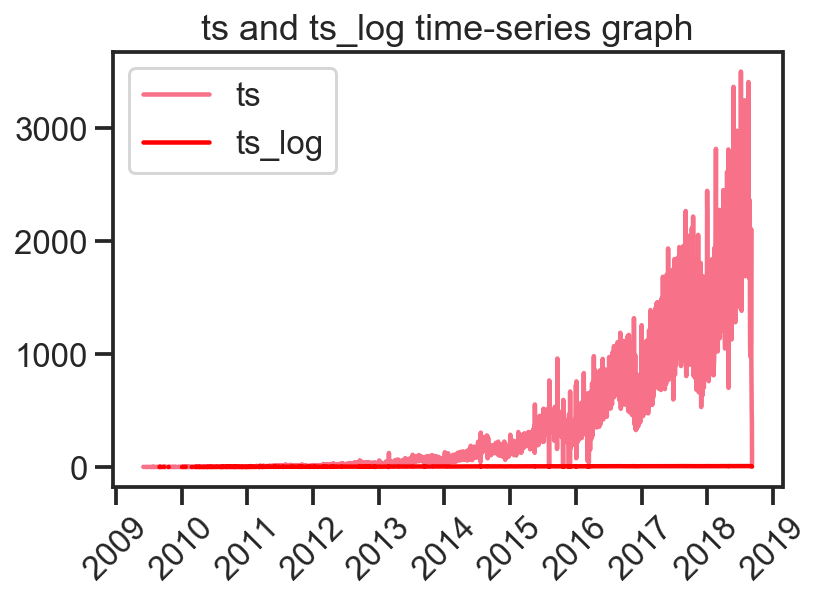

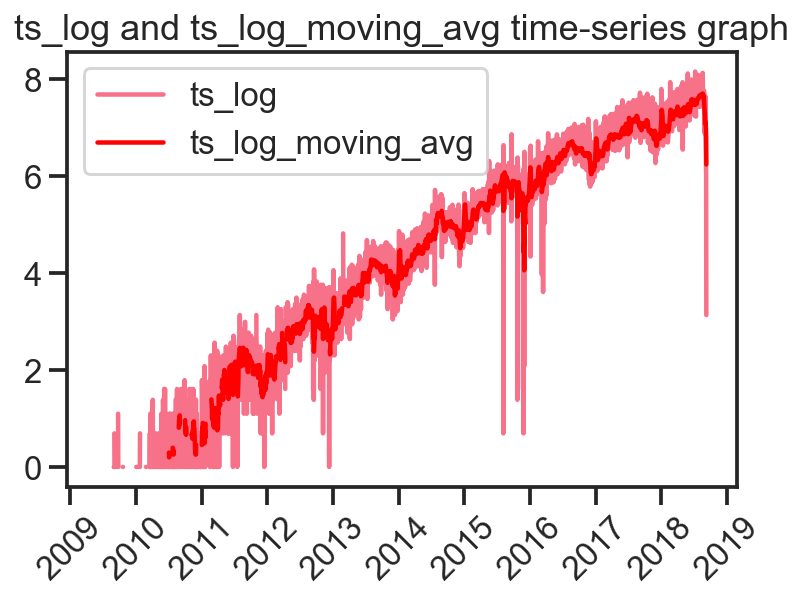

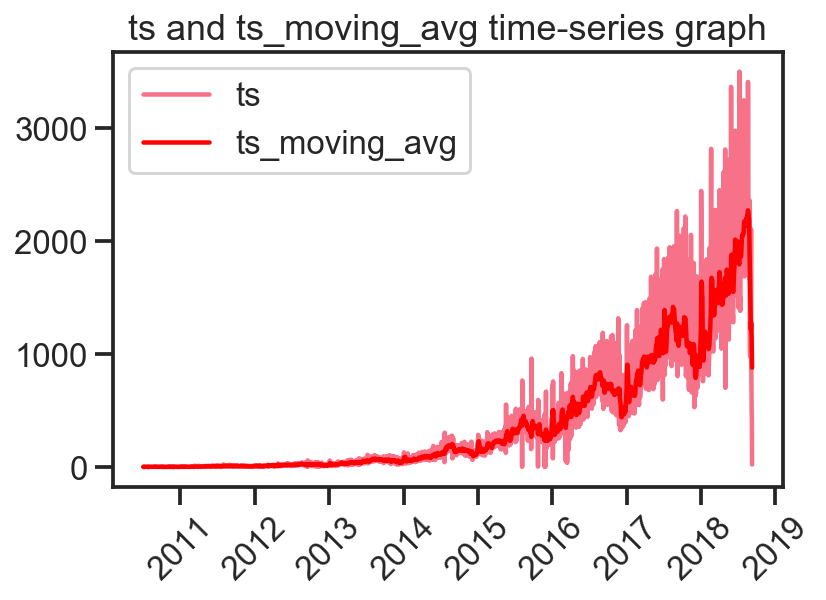

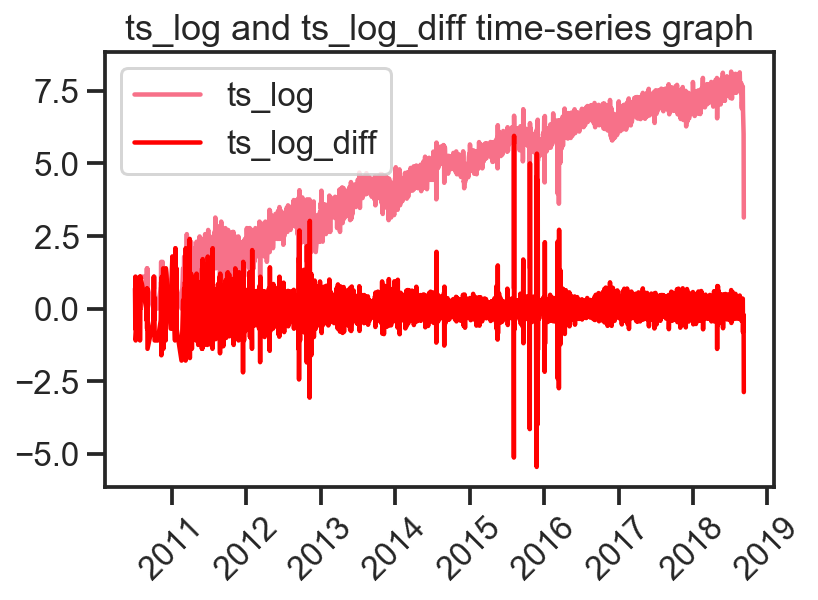

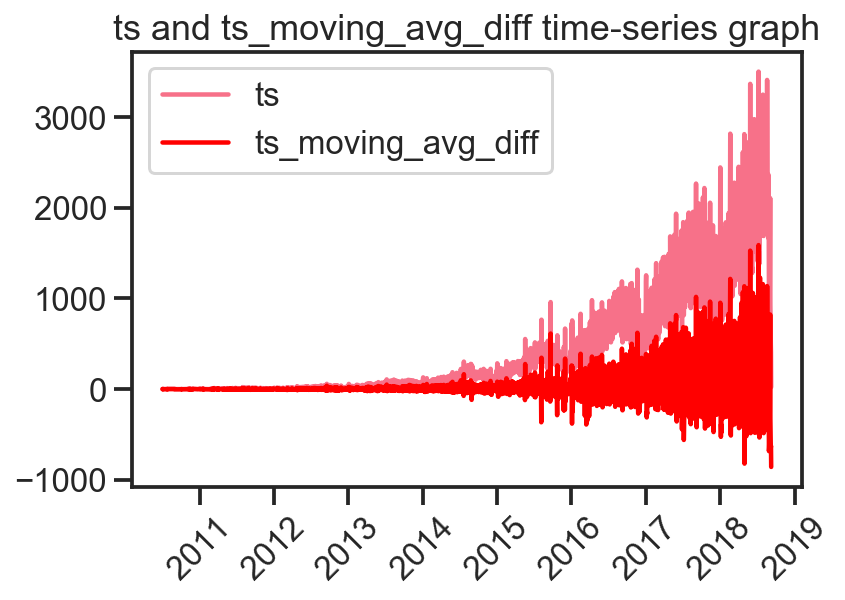

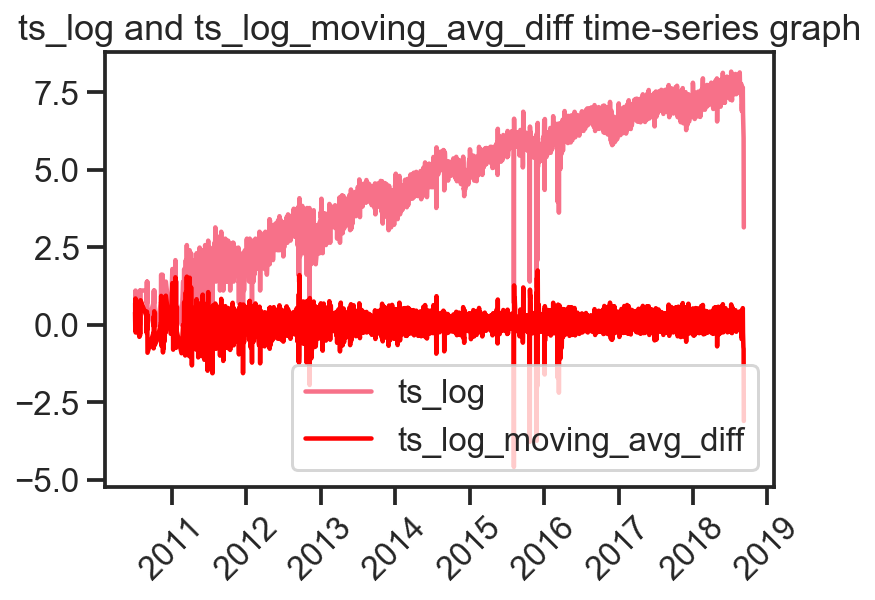

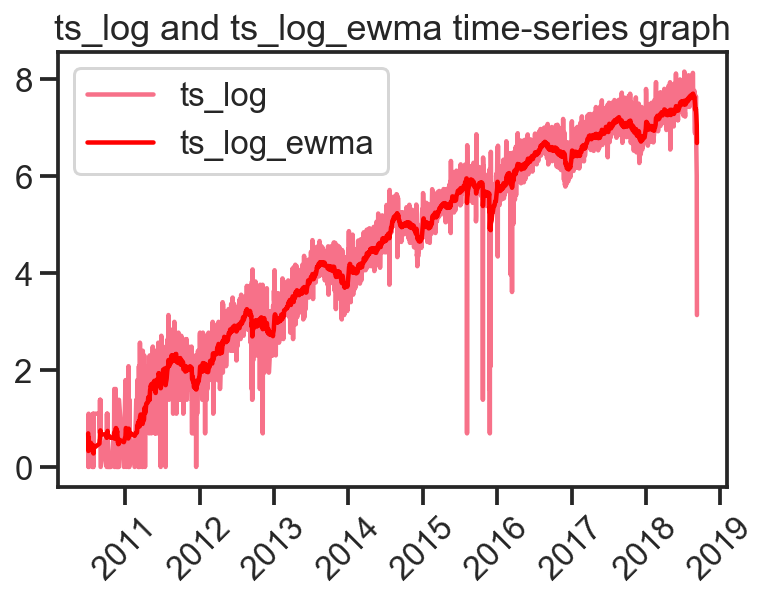

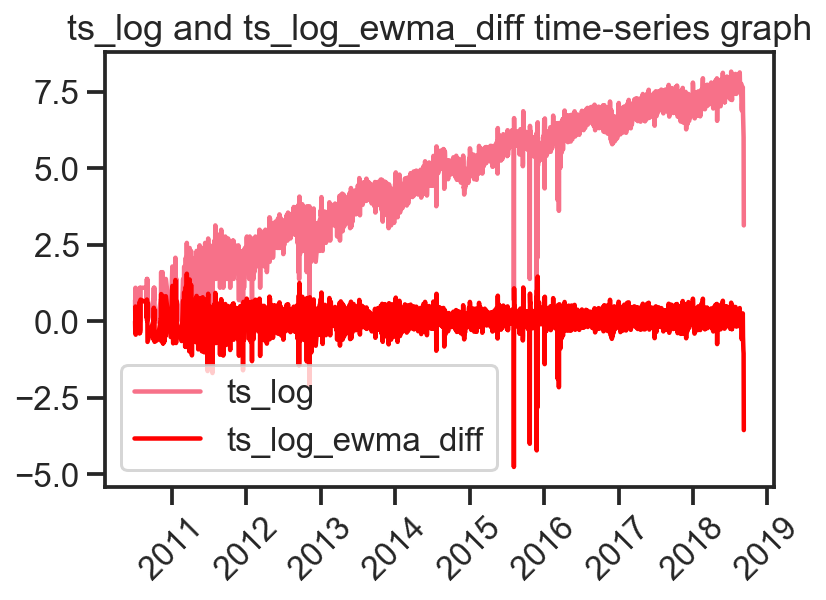

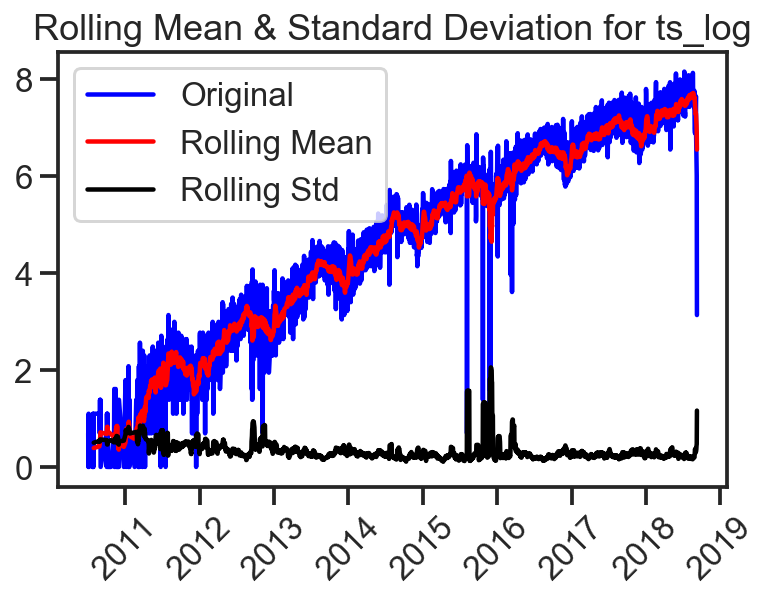

Results of Dickey-Fuller Test:
Test Statistic                   -2.260516
p-value                           0.185019
# Lags Used                      22.000000
Number of Observations Used    2720.000000
Critical Value (1%)              -3.432756
Critical Value (5%)              -2.862603
Critical Value (10%)             -2.567336
dtype: float64


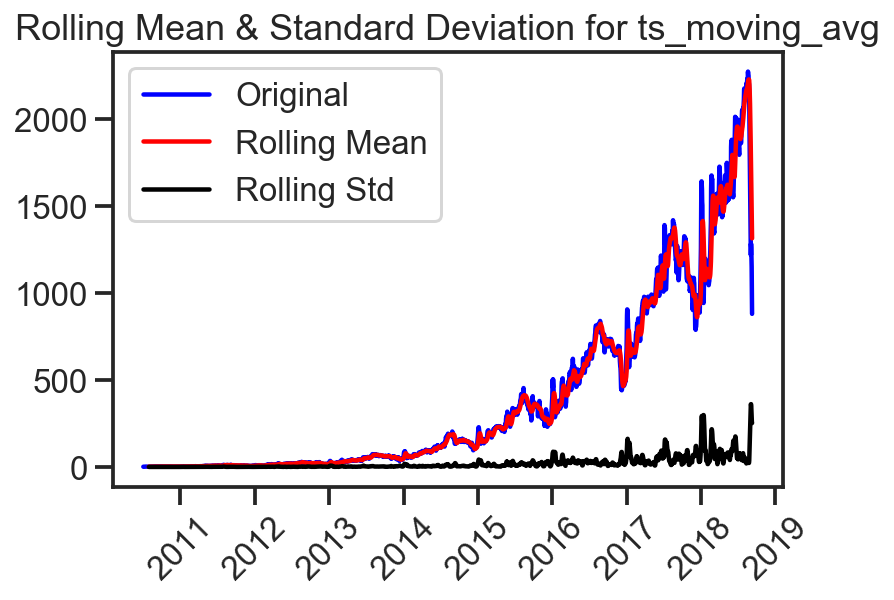

Results of Dickey-Fuller Test:
Test Statistic                   -1.207469
p-value                           0.670375
# Lags Used                      28.000000
Number of Observations Used    2714.000000
Critical Value (1%)              -3.432762
Critical Value (5%)              -2.862606
Critical Value (10%)             -2.567337
dtype: float64


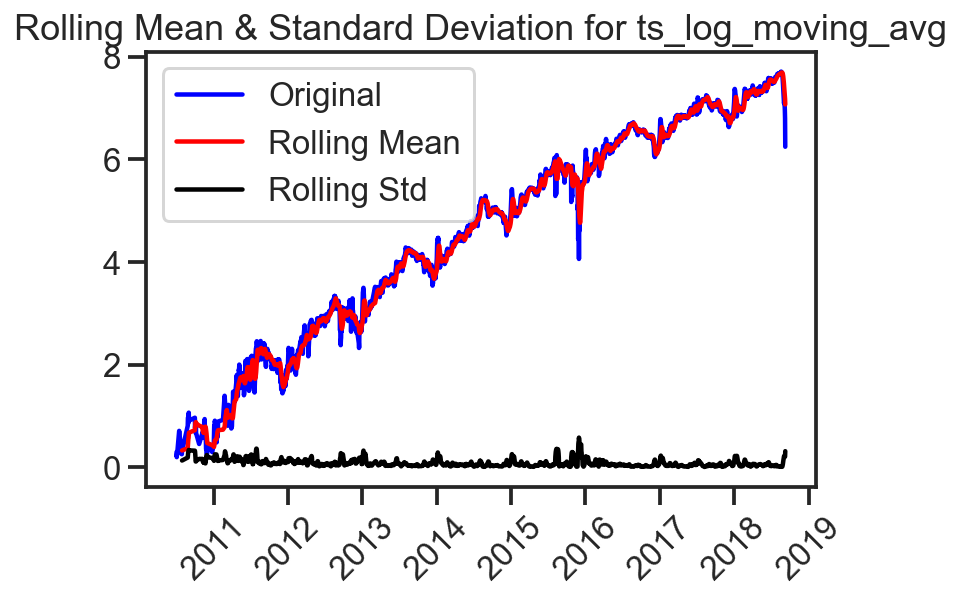

Results of Dickey-Fuller Test:
Test Statistic                   -2.278058
p-value                           0.179142
# Lags Used                      28.000000
Number of Observations Used    2714.000000
Critical Value (1%)              -3.432762
Critical Value (5%)              -2.862606
Critical Value (10%)             -2.567337
dtype: float64


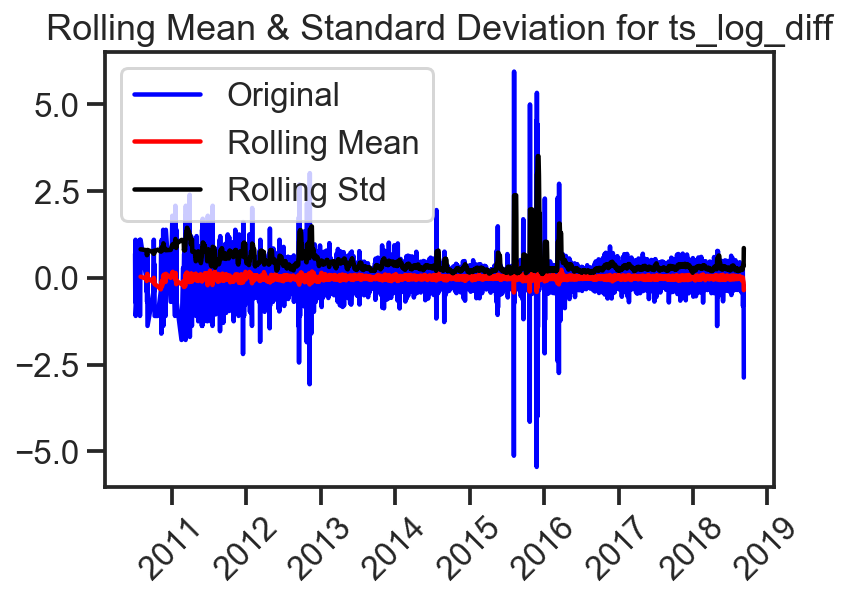

Results of Dickey-Fuller Test:
Test Statistic                -1.283012e+01
p-value                        5.898053e-24
# Lags Used                    2.100000e+01
Number of Observations Used    2.721000e+03
Critical Value (1%)           -3.432756e+00
Critical Value (5%)           -2.862603e+00
Critical Value (10%)          -2.567336e+00
dtype: float64


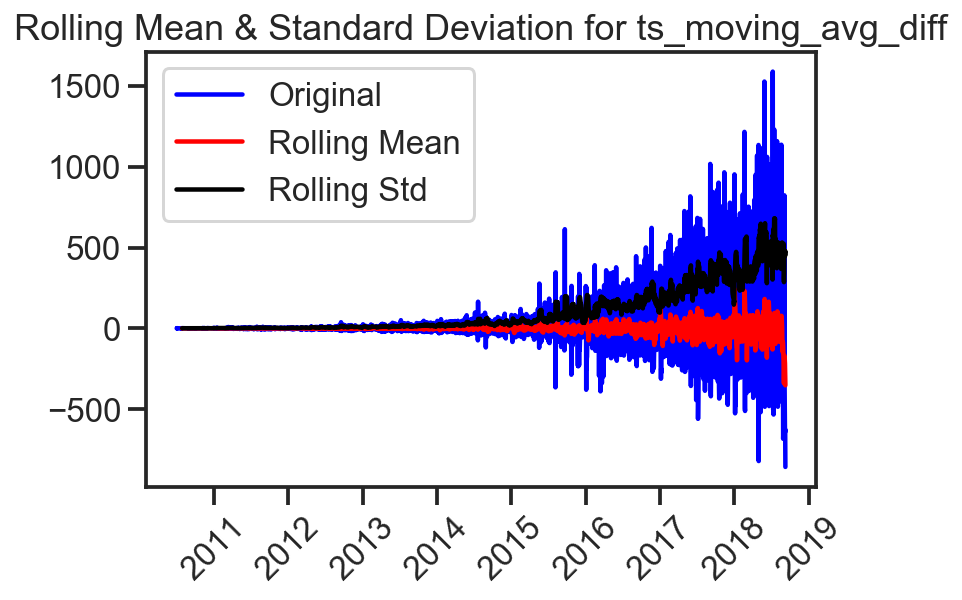

Results of Dickey-Fuller Test:
Test Statistic                   -4.974821
p-value                           0.000025
# Lags Used                      28.000000
Number of Observations Used    2714.000000
Critical Value (1%)              -3.432762
Critical Value (5%)              -2.862606
Critical Value (10%)             -2.567337
dtype: float64


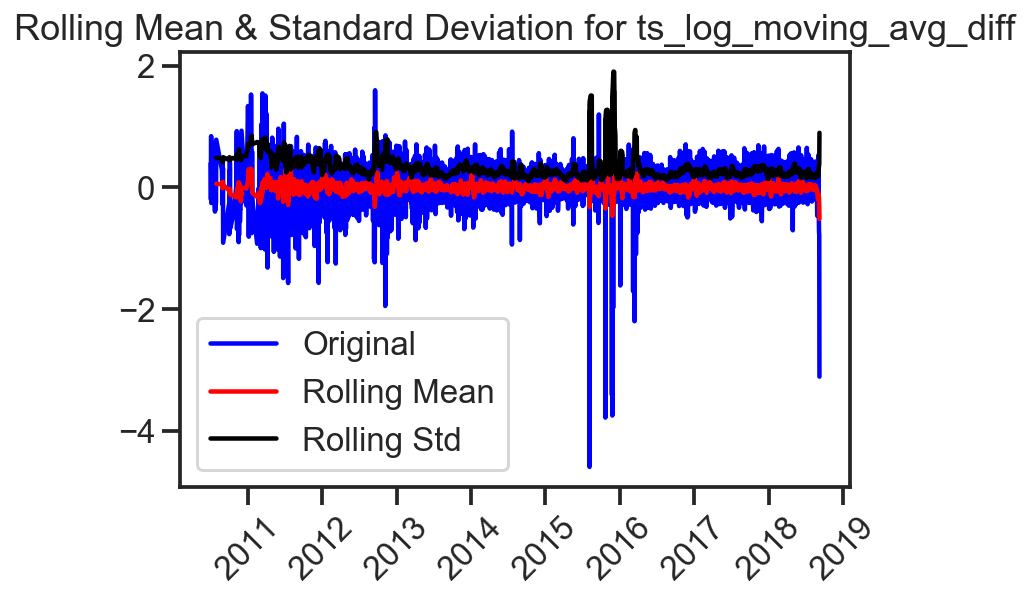

Results of Dickey-Fuller Test:
Test Statistic                -1.292892e+01
p-value                        3.736404e-24
# Lags Used                    2.200000e+01
Number of Observations Used    2.720000e+03
Critical Value (1%)           -3.432756e+00
Critical Value (5%)           -2.862603e+00
Critical Value (10%)          -2.567336e+00
dtype: float64


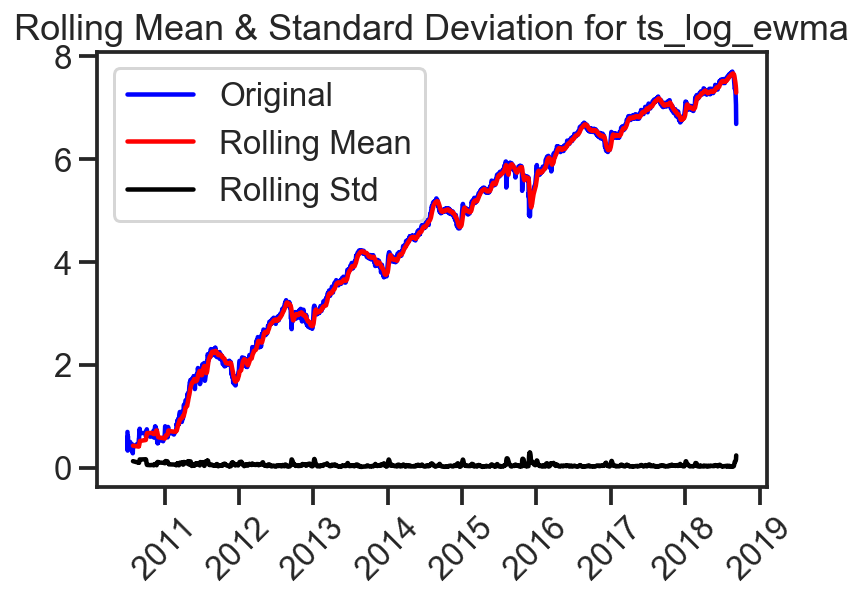

Results of Dickey-Fuller Test:
Test Statistic                   -2.296185
p-value                           0.173201
# Lags Used                      23.000000
Number of Observations Used    2719.000000
Critical Value (1%)              -3.432757
Critical Value (5%)              -2.862604
Critical Value (10%)             -2.567336
dtype: float64


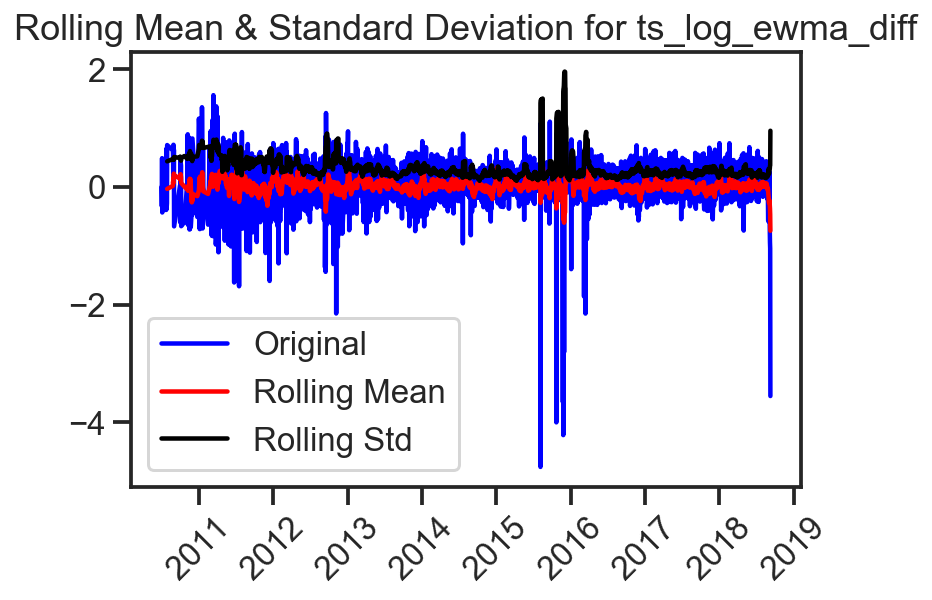

Results of Dickey-Fuller Test:
Test Statistic                -9.066491e+00
p-value                        4.418323e-15
# Lags Used                    2.200000e+01
Number of Observations Used    2.720000e+03
Critical Value (1%)           -3.432756e+00
Critical Value (5%)           -2.862603e+00
Critical Value (10%)          -2.567336e+00
dtype: float64


In [29]:
# Transformation - log ts
df_example['ts_log'] = df_example['ts'].apply(lambda x: numpy.log(x))

# Transformation - 7-day moving averages of log ts
df_example['ts_log_moving_avg'] = df_example['ts_log'].rolling(window = 7,
                                                               center = False).mean()

# Transformation - 7-day moving average ts
df_example['ts_moving_avg'] = df_example['ts'].rolling(window = 7,
                                                       center = False).mean()

# Transformation - Difference between logged ts and first-order difference logged ts
# df_example['ts_log_diff'] = df_example['ts_log'] - df_example['ts_log'].shift()
df_example['ts_log_diff'] = df_example['ts_log'].diff()

# Transformation - Difference between ts and moving average ts
df_example['ts_moving_avg_diff'] = df_example['ts'] - df_example['ts_moving_avg']

# Transformation - Difference between logged ts and logged moving average ts
df_example['ts_log_moving_avg_diff'] = df_example['ts_log'] - df_example['ts_log_moving_avg']

# Transformation - Difference between logged ts and logged moving average ts
df_example_transform = df_example.dropna()

# Transformation - Logged exponentially weighted moving averages (EWMA) ts
df_example_transform['ts_log_ewma'] = df_example_transform['ts_log'].ewm(halflife = 7,
                                                                         ignore_na = False,
                                                                         min_periods = 0,
                                                                         adjust = True).mean()

# Transformation - Difference between logged ts and logged EWMA ts
df_example_transform['ts_log_ewma_diff'] = df_example_transform['ts_log'] - df_example_transform['ts_log_ewma']

# Display data
display(df_example_transform.head())

# Plot data
plot_transformed_data(df = df_example, 
                      ts = 'ts', 
                      ts_transform = 'ts_log')
# Plot data
plot_transformed_data(df = df_example, 
                      ts = 'ts_log', 
                      ts_transform = 'ts_log_moving_avg')

# Plot data
plot_transformed_data(df = df_example_transform, 
                      ts = 'ts', 
                      ts_transform = 'ts_moving_avg')

# Plot data
plot_transformed_data(df = df_example_transform, 
                      ts = 'ts_log', 
                      ts_transform = 'ts_log_diff')

# Plot data
plot_transformed_data(df = df_example_transform, 
                      ts = 'ts', 
                      ts_transform = 'ts_moving_avg_diff')

# Plot data
plot_transformed_data(df = df_example_transform, 
                      ts = 'ts_log', 
                      ts_transform = 'ts_log_moving_avg_diff')

# Plot data
plot_transformed_data(df = df_example_transform, 
                      ts = 'ts_log', 
                      ts_transform = 'ts_log_ewma')

# Plot data
plot_transformed_data(df = df_example_transform, 
                      ts = 'ts_log', 
                      ts_transform = 'ts_log_ewma_diff')

# Perform stationarity test
test_stationarity(df = df_example_transform, 
                  ts = 'ts_log')

# Perform stationarity test
test_stationarity(df = df_example_transform, 
                  ts = 'ts_moving_avg')

# Perform stationarity test
test_stationarity(df = df_example_transform, 
                  ts = 'ts_log_moving_avg')

# Perform stationarity test
test_stationarity(df = df_example_transform,
                  ts = 'ts_log_diff')

# Perform stationarity test
test_stationarity(df = df_example_transform,
                  ts = 'ts_moving_avg_diff')

# Perform stationarity test
test_stationarity(df = df_example_transform,
                  ts = 'ts_log_moving_avg_diff')

# Perform stationarity test
test_stationarity(df = df_example_transform, 
                  ts = 'ts_log_ewma')

# Perform stationarity test
test_stationarity(df = df_example_transform,
                  ts = 'ts_log_ewma_diff')

## Decomposition: trend, seasonality, residuals
**Looking at our data:**
- De-trending and de-seasonalizing made the data (i.e., the residuals) more stationary over time. Based on **Dickey-Fuller test**, because p = < 0.05, we fail to reject the null hypothesis (that the time series is not stationary) at the p = 0.05 level, thus concluding that the **time series is stationary**.

In [30]:
def plot_decomposition(df, ts, trend, seasonal, residual):
    """
    Plot time series data
    """
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize = (15, 5), sharex = True)

    ax1.plot(df[ts], label = 'Original')
    ax1.legend(loc = 'best')
    ax1.tick_params(axis = 'x', rotation = 45)

    ax2.plot(df[trend], label = 'Trend')
    ax2.legend(loc = 'best')
    ax2.tick_params(axis = 'x', rotation = 45)

    ax3.plot(df[seasonal],label = 'Seasonality')
    ax3.legend(loc = 'best')
    ax3.tick_params(axis = 'x', rotation = 45)

    ax4.plot(df[residual], label = 'Residuals')
    ax4.legend(loc = 'best')
    ax4.tick_params(axis = 'x', rotation = 45)
    plt.tight_layout()

    # Show graph
    plt.suptitle('Trend, Seasonal, and Residual Decomposition of %s' %(ts), 
               x = 0.5, 
               y = 1.05, 
               fontsize = 18)
    plt.show()
    plt.close()

    return

/Users/natedake/.virtualenvs/intuitiveml/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/natedake/.virtualenvs/intuitiveml/lib/python3.6/site-packages/pandas/core/indexing.py:635: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


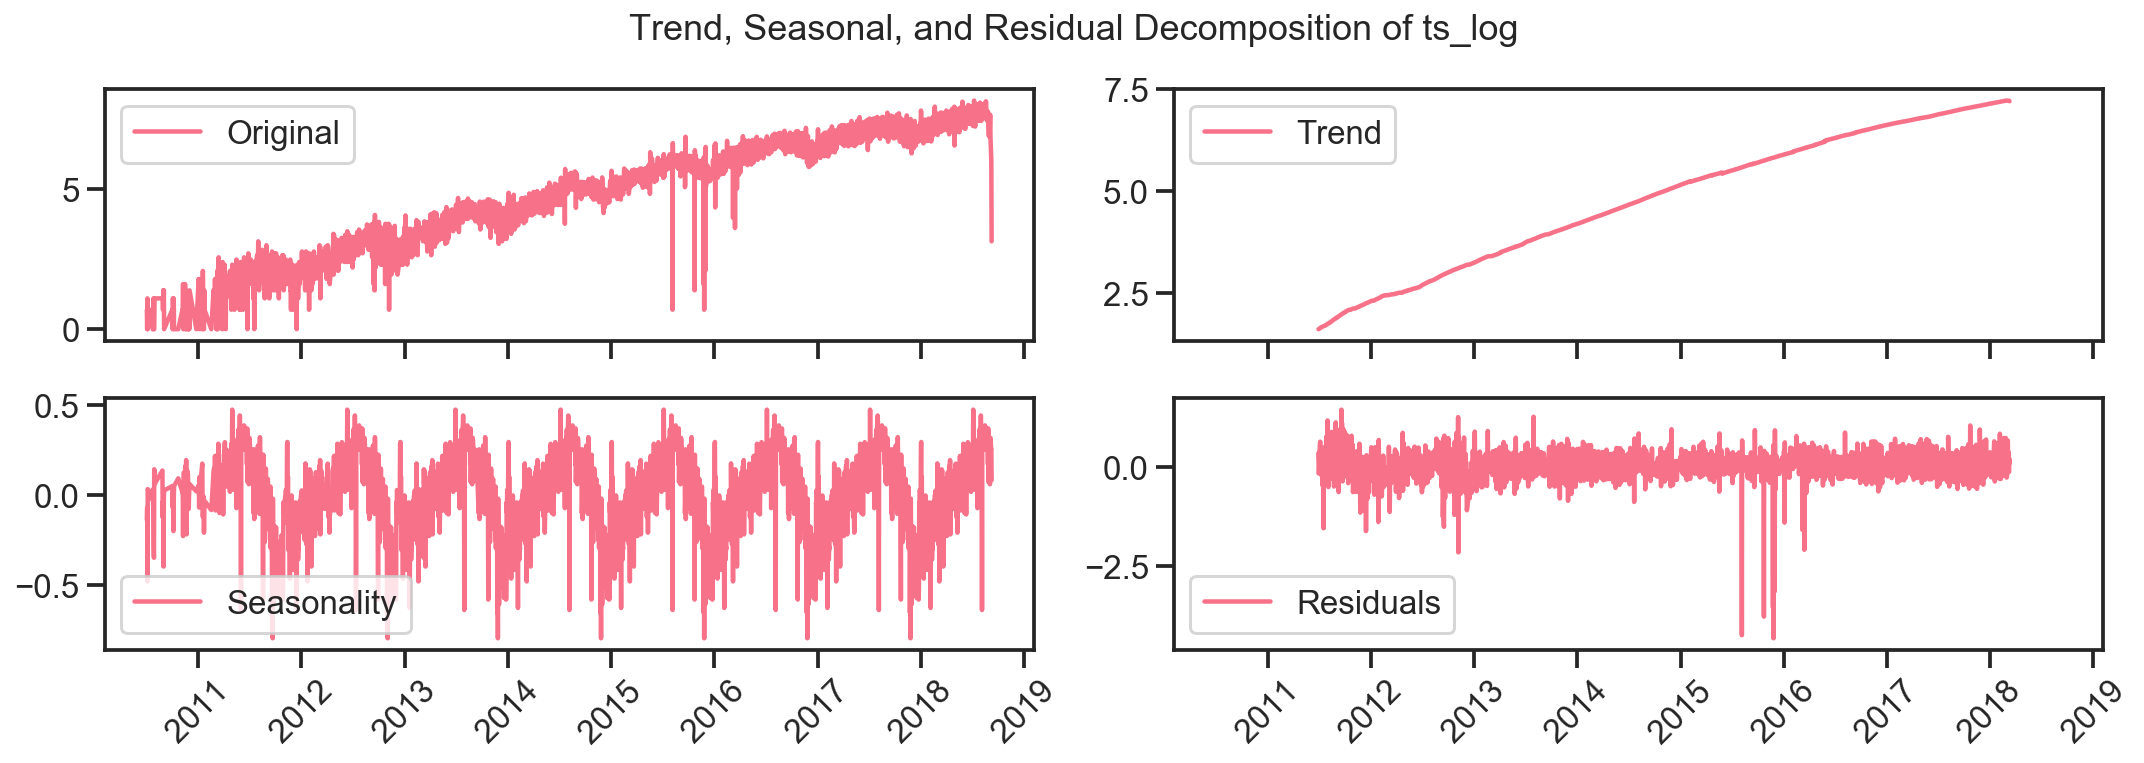

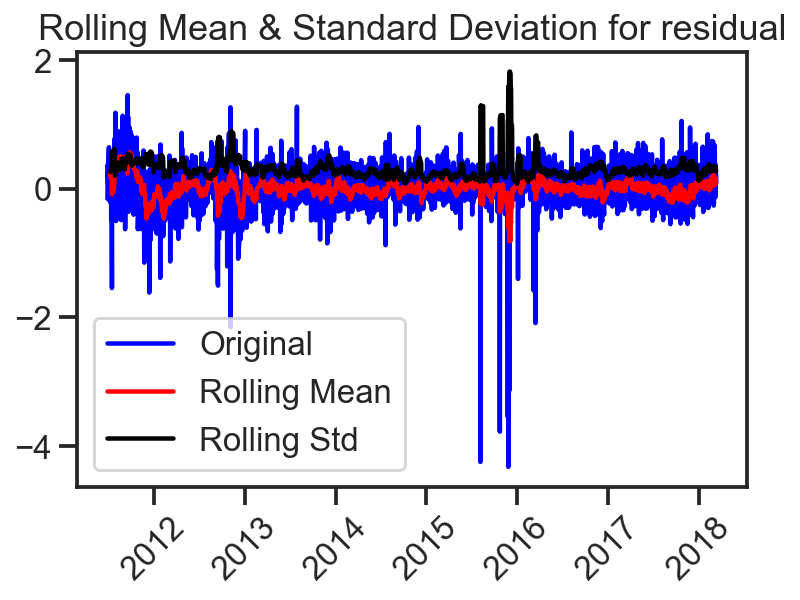

Results of Dickey-Fuller Test:
Test Statistic                -6.243743e+00
p-value                        4.629649e-08
# Lags Used                    2.700000e+01
Number of Observations Used    2.351000e+03
Critical Value (1%)           -3.433135e+00
Critical Value (5%)           -2.862770e+00
Critical Value (10%)          -2.567425e+00
dtype: float64


In [31]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df_example_transform['ts_log'], freq = 365)

df_example_transform.loc[:,'trend'] = decomposition.trend
df_example_transform.loc[:,'seasonal'] = decomposition.seasonal
df_example_transform.loc[:,'residual'] = decomposition.resid

plot_decomposition(df = df_example_transform, 
                   ts = 'ts_log', 
                   trend = 'trend',
                   seasonal = 'seasonal', 
                   residual = 'residual')

test_stationarity(df = df_example_transform.dropna(), ts = 'residual')